# Loading in Packages and dependencies to

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa as li
import os
from google.colab import drive

#mount the google drive to the notebook
drive.mount('/content/drive')

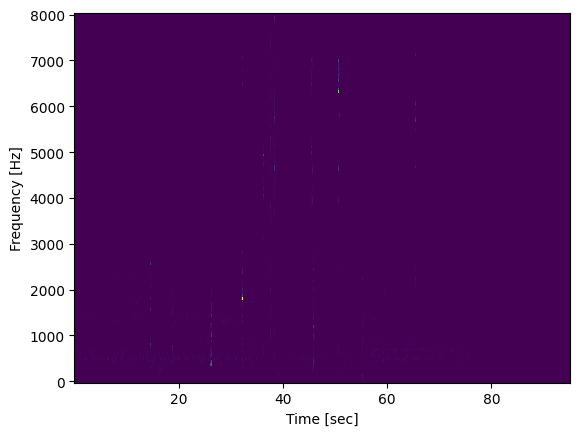

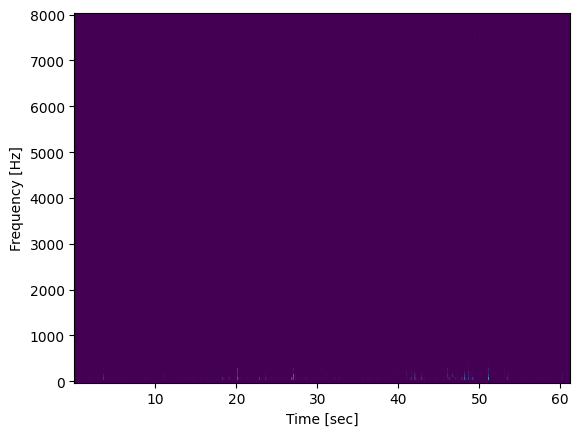

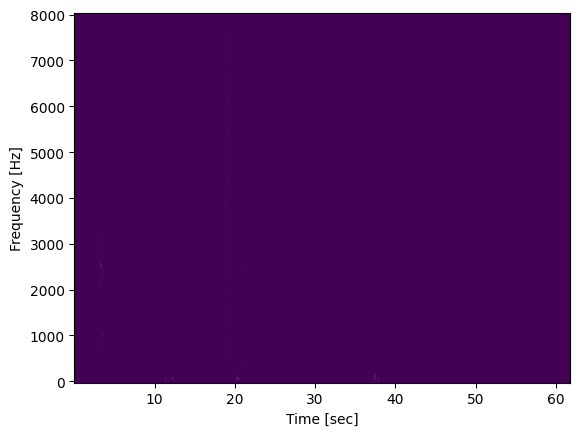

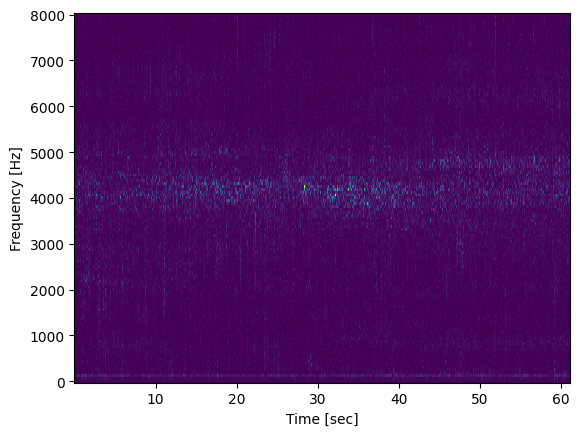

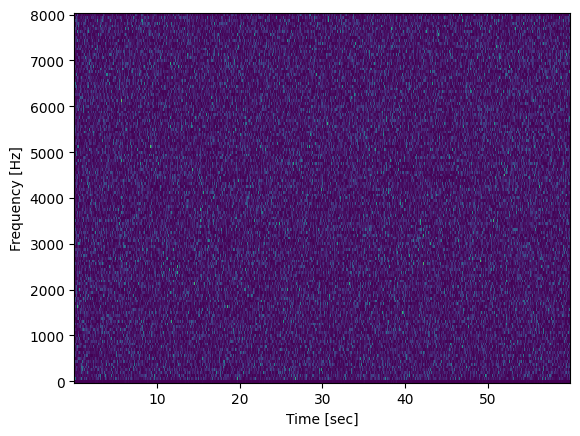

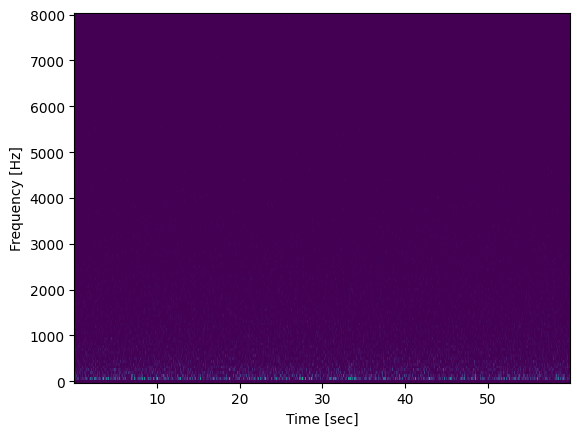

In [ ]:
#importing audio files for the 'go' english command and transforming them into spectrograms
go_files_path = '/content/drive/MyDrive/dataset/background_noise_'
go_files = os.listdir(go_files_path)

for file in go_files:
    if file.endswith('.wav'):
        file_path = os.path.join(go_files_path, file)
        samples, sample_rate = li.load(file_path, sr=16000, mono=True)
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

        plt.pcolormesh(times, frequencies, spectrogram)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

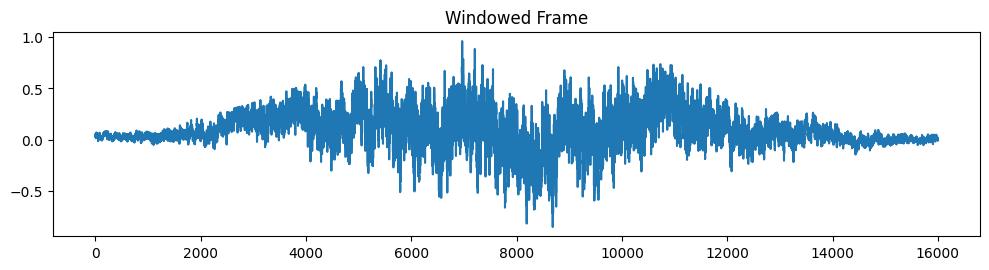

In [ ]:
#Frame blocking of the data using the windowing function w(n)
#Y(n)= x1(n) w(n), 0<=n<=N-1
#w(n)= 0.54 - 0.46cos(2πn/N-1), 0<=n<=N-1

# Define the windowing function
def window_function(n, N):
    return 0.54 - 0.46 * np.cos(2 * np.pi * n / (N - 1))

# Define the frame blocking function
def frame_blocking(x, N):
    # Ensure the length of x is a multiple of N
    x = x[:len(x)//N * N]

    # Reshape the data into frames
    frames = x.reshape(-1, N)

    # Apply the windowing function to each frame
    windowed_frames = frames * window_function(np.arange(N), N)

    return windowed_frames



# Frame blocking using the defined function
windowed_data = frame_blocking(samples, sample_rate)

# Plot the original and windowed data
plt.figure(figsize=(10, 5))

###The Samples & sample_rate have to be reshaped with the
data= np.squeeze(samples )
#a is the array to be reshaped
#newshape is the int or tuple of ints of the newshape
#order ='C' is read ints fram array a into array newshape using that order
#plt.subplot(2, 1, 1)
#plt.plot(data, sample_rate)
#plt.title('Original Data')

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(windowed_data[0])), windowed_data[0], label='Windowed Frame')
plt.title('Windowed Frame')

plt.tight_layout()
plt.show()

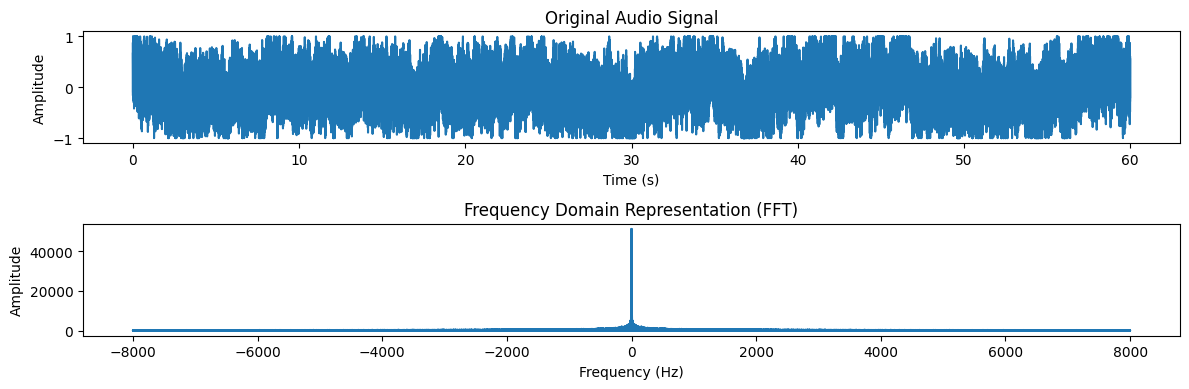

In [ ]:
#Fast Fourier Transform to turn audio time signals to frequency domain signals
#Xn = Σ(k=0 to N-1) xk  eps(-2πjkn/N), n=0,1,2,....,N-1
#Xn is the frequency, xk is the sample value, N is number of sample data

# Generate a time array based on the sample rate
time = np.arange(len(samples)) / sample_rate

# Perform FFT on the audio signal
fft_result = np.fft.fft(samples)
# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Plot the original audio signal
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(time,samples)
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the frequency domain representation using FFT
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('Frequency Domain Representation (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

#Mel Frequency Wrapping
The scale of the mel-frequency is linear low frequency and a high logarithmic frequency consisting of under 1000hz and over 1000hz . the scale is defined as

$X_n = log_{10}(\sum\limits_{k=0}^{N-1} |X(k)|H_i(k)), \space i=1,2,3,...,M$

H(k) is the value of the filter triangle I,
X(k) is the of data from the FFT process,
M is the number of filters,
N is the number of data.

In [ ]:
#Mel frequency wrapping of the transformed signal
# Number of Mel filters
num_filters = 40

# Perform FFT on the audio signal
fft_result = np.fft.fft(samples)
# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Use librosa's mel filter bank function
mel_filter_bank = li.filters.mel(sr=sample_rate, n_fft=len(fft_result), n_mels=num_filters)

# Transpose mel_filter_bank to have a shape of (N, 40)
mel_filter_bank = mel_filter_bank.T

# Apply the mel filter bank to the FFT result
mel_wrapped_signal = np.dot(np.abs(fft_result), mel_filter_bank)

# Apply the mel filter bank to the FFT result
#mel_wrapped_signal = np.dot(mel_filter_bank, np.abs(fft_result) )

# Plot the original audio signal
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(samples)) / sample_rate, samples)
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the FFT result
plt.subplot(3, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('Frequency Domain Representation (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# Plot the Mel-frequency wrapped signal
plt.subplot(3, 1, 3)
li.display.specshow(li.power_to_db(mel_wrapped_signal, ref=np.max), y_axis='mel', x_axis='time')
plt.title('Mel-frequency Wrapped Signal')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')

plt.tight_layout()
plt.show()



#Discrete Cosine Transform

$C_j = \sum\limits_{i=0}^M X_i \cos (j(i-1)/2 \frac{π}{M} )$

j is 1,2,3,...,K where K is the number of coefficients intended and M is the number of filters.

In [ ]:
#Changing the log mel spectrum to time domain to form cepstrum using the discrete cosine transform
# Number of Mel filters
num_filters = 40

# Perform FFT on the audio signal
fft_result = np.fft.fft(samples)
# Calculate the corresponding frequencies
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Use librosa's mel filter bank function
mel_filter_bank = li.filters.mel(sr = sample_rate, n_fft=len(fft_result), n_mels=num_filters)



# Reshape np.abs(fft_result) to have shape (N, 1)
fft_result_reshaped = np.abs(fft_result).reshape(-1, 1)

# Transpose mel_filter_bank to have shape (N, 40)
mel_filter_bank_transposed = mel_filter_bank.T

# Apply the mel filter bank to the FFT result
mel_wrapped_signal = np.dot(mel_filter_bank_transposed , fft_result_reshaped)

# Perform the dot product
#result = np.dot(mel_filter_bank, fft_result_reshaped)

# Take the log of the mel-wrapped signal
log_mel_spectrum = np.log(mel_wrapped_signal)

# Apply Discrete Cosine Transform (DCT) to obtain cepstrum
cepstrum = li.filters.dct(log_mel_spectrum, type=2, axis=0, norm='ortho')

# Plot the original audio signal
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(np.arange(len(samples)) / sample_rate, samples)
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('Frequency Domain Representation (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(4, 1, 3)
li.display.specshow(li.power_to_db(mel_wrapped_signal, ref=np.max), y_axis='mel', x_axis='time')
plt.title('Mel-frequency Wrapped Signal')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')

plt.subplot(4, 1, 4)
li.display.specshow(cepstrum, y_axis='mel', x_axis='time')
plt.title('Cepstrum')
plt.xlabel('Time (s)')
plt.ylabel('Cepstral Coefficients')

plt.tight_layout()
plt.show()

ValueError: ignored

In [ ]:
#extracting features from the spectrograms

# Feature extraction from the cepstrum
def extract_cepstral_features(cepstrum):
    # Basic statistics
    mean_cepstrum = np.mean(cepstrum, axis=1)
    std_cepstrum = np.std(cepstrum, axis=1)

    # Other features  to extract
    # For example, you can compute the first and second derivatives
    delta_cepstrum = li.feature.delta(cepstrum)
    delta2_cepstrum = li.feature.delta(cepstrum, order=2)

    # Concatenate all features
    features = np.concatenate([mean_cepstrum, std_cepstrum, delta_cepstrum, delta2_cepstrum], axis=0)

    return features

# Extract features from the cepstrum
cepstral_features = extract_cepstral_features(cepstrum)

# Print or use the extracted features as needed
print("Cepstral Features Shape:", cepstral_features.shape)
print("Cepstral Features:", cepstral_features)


In [ ]:
#feature engineering, spliting the dataset


# Split the data into training (80%), testing (10%), and validation (10%) sets
X_train, X_temp, X, Y = train_test_split(cepstral_features, cepstral_features, test_size=0.2, random_state=42)
X_val, X_test, x, y = train_test_split(X_temp, X_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)


#CNN-LSTM

Convolutional neural networks will take the spectrograms through various Convolution layers, Activation and Max Pooling layers. It will then be fed through a tailored Long Short Term Memory RNN for forgetting, remembering and updating the data.

In [ ]:
#trainig of the speech intent classifier training set using CNN the neurons should all share the same weight of the connection
#first feature map plus the ReLu, 32 filter layers, 3x3 kernels using same padding and 1 stride
#First pooled feature maps, pooling 1
#second feature maps plus the ReLu
#second pooled feature maps, pooling 2
#third frature maps plus ReLu
#third pooled feature maps
import tensorflow

# Assuming you have your training data and labels, replace these placeholders with your actual data
train_data = (X_train,X_temp)
train_labels = (X,Y)

# Create a Sequential model
model = Sequential()

# First feature map plus ReLU, 32 filter layers, 3x3 kernels, same padding, and 1 stride
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(input_shape)))
# First pooled feature maps, pooling 1
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second feature maps plus ReLU
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# Second pooled feature maps, pooling 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third feature maps plus ReLU
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# Third pooled feature maps
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for the fully connected layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Output layer with the number of classes (adjust as needed)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#number of epochs
epochs= '#'

#ente the batch size
batch_size = '#'

#


# Train the model
model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)

In [ ]:
#Testing with test set